<a href="https://colab.research.google.com/github/NiclasFenton-Wiegleb/Itinerary-Generator/blob/main/Itinerary_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Itinerary Generator Project

The idea behind this project is to create a dataset of different locations in Manchester and create a reinforcement learning algorithm that plots an optimised route to follow. Locations are organised in a hierarchy of start point, brunch, activity, drinks and dinner - in that order.

In [ ]:
#Install dependencies

!pip install "geodatasets" "contextily" "tensorflow>=2.4" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
#Import libraries

from shapely.geometry import Point
import numpy as np
import pylab as plt
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path
import contextily as cx
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

In [ ]:
#Load test dataframe

df = pd.read_csv("./ItineraryGenerator_TestData.csv")

df.head(10)

,name,lat_coordinates,long_coordinates,address,hierarchy,category,child_friendly,price,quality_score
0,Evelyn's Cafe,53.483090,-2.23579,"44 Tib St, Manchester M4 1LA",1,brunch,1,20,3
1,Manchester Art Gallery,53.479720,-2.24077,"Mosley St, Manchester M2 3JL",2,activity,1,0,2
2,Piccadilly Gardens,53.482560,-2.24153,"Piccadilly Gardens, Manchester M60 1AY",0,start_point,1,0,1
3,Moose Coffee,53.480700,-2.24062,"20 York St, Manchester M2 2BB",1,brunch,1,15,2
4,Crazy Pedro's - NQ,53.482490,-2.23656,"Short St, Manchester M4 1AA",3,dinner,0,15,2
5,NQ64,53.482170,-2.23782,"12 Tib St, Manchester M4 1SH",4,drinks,0,20,3
6,Crazy Pedro's - Spinningfield,53.481312,-2.25055,"55-57 Bridge St, Manchester M3 3BQ",3,dinner,0,15,2
7,Matt and Phreds,53.483620,-2.23488,"64 Tib St, Manchester M4 1LW",2,activity,0,15,3
8,Northern Soul,53.483089,-2.23579,"Unit G20, 21, 44 Tib St, Manchester M4 1LA",1,brunch,1,10,3
9,Factory International,53.477650,-2.25869,"Aviva Studios, Water St, Manchester M3 4JQ",2,activity,1,20,3


In [ ]:
#Convert dataframe to geodataframe

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long_coordinates, df.lat_coordinates), crs="EPSG:4666"
)

gdf.head(10)

,name,lat_coordinates,long_coordinates,address,hierarchy,category,child_friendly,price,quality_score,geometry
0,Evelyn's Cafe,53.483090,-2.23579,"44 Tib St, Manchester M4 1LA",1,brunch,1,20,3,POINT (-2.23579 53.48309)
1,Manchester Art Gallery,53.479720,-2.24077,"Mosley St, Manchester M2 3JL",2,activity,1,0,2,POINT (-2.24077 53.47972)
2,Piccadilly Gardens,53.482560,-2.24153,"Piccadilly Gardens, Manchester M60 1AY",0,start_point,1,0,1,POINT (-2.24153 53.48256)
3,Moose Coffee,53.480700,-2.24062,"20 York St, Manchester M2 2BB",1,brunch,1,15,2,POINT (-2.24062 53.48070)
4,Crazy Pedro's - NQ,53.482490,-2.23656,"Short St, Manchester M4 1AA",3,dinner,0,15,2,POINT (-2.23656 53.48249)
5,NQ64,53.482170,-2.23782,"12 Tib St, Manchester M4 1SH",4,drinks,0,20,3,POINT (-2.23782 53.48217)
6,Crazy Pedro's - Spinningfield,53.481312,-2.25055,"55-57 Bridge St, Manchester M3 3BQ",3,dinner,0,15,2,POINT (-2.25055 53.48131)
7,Matt and Phreds,53.483620,-2.23488,"64 Tib St, Manchester M4 1LW",2,activity,0,15,3,POINT (-2.23488 53.48362)
8,Northern Soul,53.483089,-2.23579,"Unit G20, 21, 44 Tib St, Manchester M4 1LA",1,brunch,1,10,3,POINT (-2.23579 53.48309)
9,Factory International,53.477650,-2.25869,"Aviva Studios, Water St, Manchester M3 4JQ",2,activity,1,20,3,POINT (-2.25869 53.47765)


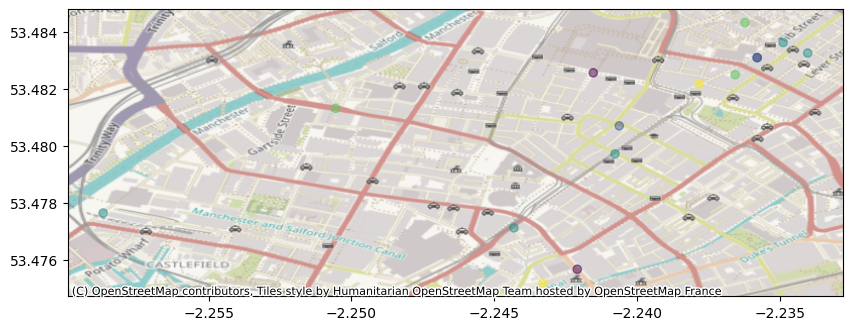

In [ ]:
#Plot datapoints on basemap

ax = gdf.plot(figsize=(10, 10), alpha=0.5, column = "hierarchy")
cx.add_basemap(ax, crs="EPSG:4666")


In [ ]:
#Create dataframe with edges and distances

df_edges = pd.DataFrame(columns=["edges", "distance"])

edges=[]
distance=[]

for i in range(len(gdf)):
  #select point 1
  point_1 = i
  hierarchy_1 = df["hierarchy"][i]
  #iterate over df and find points above in the hierarchy
  for j in range(len(gdf)):
    #select point 2
    point_2 = j
    hierarchy_2 = df["hierarchy"][j]

    #Check for hierarchy higher than point 1
    if hierarchy_2 == hierarchy_1 + 1:

      #Append edges
      edges.append((point_1, point_2))

      #TO DO - Calculate distance between points

    else:
      continue

#Add distance between points to dataframe
for x in edges:

    index1 = x[0]
    index2 = x[1]
    pnt1 = gdf.geometry[index1]
    pnt2 = gdf.geometry[index2]

    points_df = gpd.GeoDataFrame({'geometry': [pnt1, pnt2]}, crs='EPSG:4666')
    points_df = points_df.to_crs('EPSG:5234')
    points_df2 = points_df.shift() #We shift the dataframe by 1 to align pnt1 with pnt2
    dis = points_df.distance(points_df2)

    #Append distance to list
    distance.append(dis[1])

df_edges["edges"] = edges
df_edges["distance"] = distance

df_edges

,edges,distance
0,"(0, 1)",619.105168
1,"(0, 7)",104.546440
2,"(0, 9)",2026.378604
3,"(0, 11)",1079.474674
4,"(0, 13)",147.154357
5,"(1, 4)",515.273393
6,"(1, 6)",833.396618
7,"(1, 12)",736.053363
8,"(2, 0)",477.452557
9,"(2, 3)",267.026705


In [ ]:
# how many points in graph? x points
MATRIX_SIZE = len(df.index)

R = np.zeros((MATRIX_SIZE,MATRIX_SIZE))
#Note - none of the edges have a distance close to 5000m
R = np.full_like(R, -5000)

In [ ]:
goal = []

for i in range(len(df.index)):

  if df.hierarchy[i] == 4:
    goal.append(i)
  else:
    continue


# The negative of the distance value for each edge and 2000 as a reward for reaching the goal
for ind in range(len(df_edges.index)):
    dis = df_edges.distance[ind]
    edge = df_edges.edges[ind]
    if edge[1] in goal:
        R[edge] = 2000
    else:
        R[edge] = -abs(dis)

    if edge[0] in goal:
        R[edge[::-1]] = 2000
    else:
        # reverse of point
        R[edge[::-1]]= -abs(dis)

# add goal point round trip
R[goal,goal]= 2000

R

array([[-5000.        ,  -619.1051681 ,  -477.45255721, -5000.        ,
        -5000.        , -5000.        , -5000.        ,  -104.54644011,
        -5000.        , -2026.3786045 , -5000.        , -1079.47467426,
        -5000.        ,  -147.15435713, -1145.05873332],
       [ -619.1051681 , -5000.        , -5000.        ,  -135.62197123,
         -515.27339311, -5000.        ,  -833.39661751, -5000.        ,
         -619.00179796, -5000.        , -5000.        , -5000.        ,
         -736.05336334, -5000.        , -5000.        ],
       [ -477.45255721, -5000.        , -5000.        ,  -267.02670471,
        -5000.        , -5000.        , -5000.        , -5000.        ,
         -477.43150281, -5000.        , -5000.        , -5000.        ,
        -5000.        , -5000.        , -5000.        ],
       [-5000.        ,  -135.62197123,  -267.02670471, -5000.        ,
        -5000.        , -5000.        , -5000.        ,  -620.13924011,
        -5000.        , -1543.9075276

This equation, known as the Bellman equation, tells us that the maximum future reward.

```
Q[current_state, action] = R[current_state, action] + gamma * max_value

print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)
```

In [ ]:
#Framing Q Matrix
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# learning parameter
gamma = 0.8

initial_state = list(df.index[df.hierarchy == 0])[0]

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= -5000)[0]
    return av_act

available_act = available_actions(initial_state)

def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)

def update(current_state, action, gamma):

    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]

    Q[current_state, action] = R[current_state, action] + gamma * max_value
    print('max_value', R[current_state, action] + gamma * max_value)

    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)

update(initial_state, action, gamma)


max_value -5000.0


0

In [ ]:
# Training
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    print ('Score:', str(score))

max_value -233.33358793157117
Score: 0
max_value -2026.3786044992396
Score: 0
max_value -5000.0
Score: 0
max_value -5000.0
Score: 0
max_value -5000.0
Score: 0
max_value -5000.0
Score: 0
max_value -5000.0
Score: 0
max_value -5000.0
Score: 0
max_value -208.13727006039488
Score: 0
max_value 2000.0
Score: -1773.3924731245602
max_value -477.45255720934483
Score: -1797.2651009850274
max_value -5000.0
Score: -2047.2651009850274
max_value -5000.0
Score: -2297.265100985028
max_value -833.3966175102905
Score: -2338.934931860542
max_value -5000.0
Score: -2588.934931860542
max_value -5000.0
Score: -2838.934931860542
max_value -1543.9075276771598
Score: -2916.1303082444
max_value -267.0267047128355
Score: -2929.481643480042
max_value -5000.0
Score: -3179.481643480042
max_value -104.54644011215233
Score: -3184.7089654856495
max_value -1937.7318328661154
Score: -3281.595557128955
max_value -5000.0
Score: -3531.595557128955
max_value -702.3332418625682
Score: -3566.7122192220836
max_value -233.5862693

In [ ]:
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

Trained Q matrix:
[[-46.03613322  17.36670195  -2.56613822 -51.83596464 -68.22907145
  -46.39576859 -28.9291263   42.25587297 -46.03718478   6.52992778
   -4.63523576   8.28636745   0.93974966  14.31441395 -10.17790057]
 [ 13.74474408 -42.41417535 -64.54918317  14.54243458  62.13749608
  -38.018028    27.92756968 -24.54657718  13.74510309 -45.93930988
  -48.07169508 -18.48565205  27.91515646 -51.90661648 -62.78171319]
 [ 15.6777093  -18.51907458 -58.02962346  12.74930999   0.
    0.93974966 -28.9291263  -24.54657718   4.93636339 -45.93930988
   -4.63523576 -18.48565205   0.93974966 -51.90661648 -62.78171319]
 [-34.42437308  20.49138351   0.30529389 -34.74438767   0.93974966
  -46.39576859 -28.9291263   35.22018937 -46.03718478   1.22188617
   -4.63523576  41.85585473 -22.22693383   7.50162978  -4.13655073]
 [-46.03613322  18.78357107 -58.02962346 -51.83596464 -28.9291263
   86.4610264  -28.9291263   -2.84020253   0.          -4.15216716
   47.44900495   9.70512936 -22.22693383  13.1349

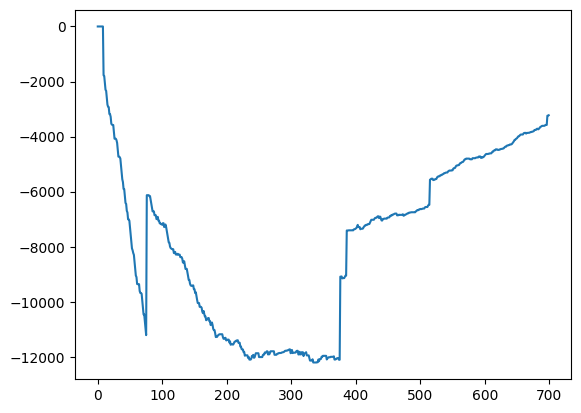

In [ ]:
plt.plot(scores)
plt.show()

From the graph above, we can see that our model started learning from ~380 itirations onwards. Longer training might show a better performance, as the graph did not plateau yet.

In [ ]:
# Testing

with tf.device("/device:GPU:0"):

    def f():
      current_state = 2

      steps = [current_state]

      while current_state != 4:

        next_step_index = tnp.where(Q[current_state,] == tnp.max(Q[current_state,]))[1]

        if next_step_index.shape[0] > 1:
            next_step_index = int(np.random.choice(next_step_index, size = 1))
        else:
            next_step_index = int(next_step_index)

        steps.append(next_step_index)
        current_state = next_step_index
    f()

In [ ]:
print("Most efficient path:")
print(steps)